# Importing and preprocessing of data

In [ ]:
! NotebookApp.iopub_data_rate_limit=90000000.0 (bytes/sec)
! NotebookApp.rate_limit_window=3.0 (secs)

In [20]:
from google.colab import drive

drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [21]:
TXTS_PATH = '/content/drive/My Drive/Becode/Kpmg/selection_fr'

In [22]:
import os

In [23]:
import pandas as pd

In [24]:
RESPONSES_PATH = '/content/drive/My Drive/Becode/Kpmg/responses_2018_now.json'

In [25]:
txt_filenames = [f for f in os.listdir(TXTS_PATH) if f.endswith(".txt")]

In [26]:
#reading json file to retrieve tags
responses = pd.read_json(RESPONSES_PATH)

In [27]:
#filtering only relevant columns
columns = ['jcId', 'jcFr', 'titleFr', 'themesFr', 'scopeFr', 'noScopeFr', 'documentLink']
responses2 = responses.copy(deep=True).loc[:,columns]
#getting txt_name from original pdf name
responses2["txt_name"] = responses2["documentLink"]
responses2["txt_name"] = responses2["txt_name"].str.replace("/","-")
responses2["txt_name"] = responses2["txt_name"].str.replace(".pdf","_FR.txt")
#filtering json only for selected files and columns
columns += ['txt_name']
responses2 = responses2.loc[responses2.txt_name.isin(txt_filenames), columns]
responses2.head(2)

,jcId,jcFr,titleFr,themesFr,scopeFr,noScopeFr,documentLink,txt_name
34,1110000,COMMISSION PARITAIRE DES CONSTRUCTIONS METALLI...,modification du régime de pension sectoriel so...,[PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES],None,[les employeurs et ouvriers des entreprises ex...,111/111-2018-013525.pdf,111-111-2018-013525_FR.txt
35,1110000,COMMISSION PARITAIRE DES CONSTRUCTIONS METALLI...,allocation spéciale compensatoire,[PRIME SYNDICALE],None,None,111/111-2018-012196.pdf,111-111-2018-012196_FR.txt


In [28]:
#generating all possible FR themes
themes_fr = []
for r in  responses2.themesFr:
    if r is not None:
        for t in r:
            if t not in themes_fr:
                themes_fr += [t]
len(themes_fr)


53

In [29]:
#code to retrieve the entire body
#%%
for filename in responses2.txt_name.to_list():
    # filename = responses2.txt_name.to_list()[10] #test
    file_path = os.path.join(TXTS_PATH, filename)
    with open(file_path, 'r', encoding="utf8") as f:
        #to retrieve entire body not necessary
        responses2.loc[responses2.txt_name == filename, "doc_bodies"] = f.read()
        f.close()

In [30]:
t = themes_fr[0]
mask = responses2.dropna(axis=0, subset=['themesFr']).themesFr.map(lambda x: t in x)

In [31]:
len(responses2)

549

In [33]:
 len(responses2.dropna(axis=0, subset=['themesFr'])[mask])

35

# Preprocessing for NLP

In [46]:
from pandas import Series

from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
import nltk

from wordcloud import WordCloud

from collections import Counter

from typing import List
from typing import Dict

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [47]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [48]:

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [50]:
 nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [36]:
def lemmatize(text_tokens: List[str]) -> List[str]:
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    # Instantiate the WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    # Lemmatize all tokens into a new list: lemmatized
    texts_lemmatized = [wordnet_lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in text_tokens]
    return texts_lemmatized

In [143]:
def tokenize_text(text:str, stop_words: List[str] = None, named_entities: List[str] = None,
               lenght_min: int=2) -> List[str]:
    # split string into words (tokens)
    tokens = word_tokenize(text.lower())
    # keep strings with only alphabets
    tokens = [t for t in tokens if t.isalpha()]
    tokens = lemmatize(tokens)
    # remove short words, they're probably not useful
    tokens = [t for t in tokens if len(t) > lenght_min]
    # remove stopwords
    if stop_words is not None:
      tokens = [t for t in tokens if t not in stop_words]
    # remove
    if named_entities is not None:
    	tokens = [t for t in tokens if t not in named_entities]
    return tokens


In [83]:
    def clean_text(text:str, stop_words: List[str] = None, named_entities: List[str] = None,
                   lenght_min: int=2) -> str:
        tokens = tokenize_text(text, stop_words, named_entities, lenght_min)
        text_cleaned = " ".join(tokens)
        return text_cleaned

In [55]:
responses2["bodies_cleaned"] = responses2["doc_bodies"].apply(clean_text)

In [68]:
doc_ex = responses2.loc[:,"doc_bodies"].values[0]
print(doc_ex)

Neerlegging-Dépôt: 18/12/2018 Regist.-Enregistr.: 07/01/2019 N°: 149887/C0/111

COMMISSION PARITAIRE DES CONSTRUCTIONS | METALLIQUE, MECANIQUE ET ELECTRIQUE (PC | |

CONVENTION COLLECTIVE DE TRAVAIL DU 17 DECEMBRE 2018 MODIFIANT LE REGIME DE PENSION SECTORIEL SOCIAL, LE REGLEMENT

DE PENSION ET LE REGLEMENT DE

SOLIDARITE | CHAPITRE 1 - CHAMP D'APPLICATION | | Article 1 | |

$1. La présente convention s'applique aux employeurs et ouvriers des entreprises ressortissant | à la Commission Paritaire 111 des constructions; métallique, mécanique et électrique, à l'exclusion des employeurs et ouvriers des entreprises exemptées du paiement d’une cotisation pour le régime de pension sectoriel, sur la base d'un accord d'entreprise relatif à l'instauration ou à l'élargissement d'un régime de pension complémentaire, conclu au plus tard le 31: décembre 1999, et pour autant que ce régime ait été | approuvé par le Fonds de Sécurité d'Existence des Fabrications Métalliques (créé par décision du 13, ja

Neerlegging-Dépôt: 18/12/2018 Regist.-Enregistr.: 07/01/2019 N°: 149887/C0/111

COMMISSION PARITAIRE DES CONSTRUCTIONS | METALLIQUE, MECANIQUE ET ELECTRIQUE (PC | |

CONVENTION COLLECTIVE DE TRAVAIL DU 17 DECEMBRE 2018 MODIFIANT LE REGIME DE PENSION SECTORIEL SOCIAL, LE REGLEMENT

DE PENSION ET LE REGLEMENT DE

SOLIDARITE | CHAPITRE 1 - CHAMP D'APPLICATION | | Article 1 | |

$1. La présente convention s'applique aux employeurs et ouvriers des entreprises ressortissant | à la Commission Paritaire 111 des constructions; métallique, mécanique et électrique, à l'exclusion des employeurs et ouvriers des entreprises exemptées du paiement d’une cotisation pour le régime de pension sectoriel, sur la base d'un accord d'entreprise relatif à l'instauration ou à l'élargissement d'un régime de pension complémentaire, conclu au plus tard le 31: décembre 1999, et pour autant que ce régime ait été | approuvé par le Fonds de Sécurité d'Existence des Fabrications Métalliques (créé par décision du 13, ja

In [69]:
cleaned_ex = responses2.loc[:,"bodies_cleaned"].values[0]
print(cleaned_ex)

commission paritaire construction metallique mecanique electrique convention collective travail decembre modifiant regime pension sectoriel social reglement pension reglement solidarite chapitre champ article présente convention aux employeurs ouvriers entreprises ressortissant commission paritaire construction métallique mécanique électrique employeurs ouvriers entreprises exemptées paiement une cotisation pour régime pension sectoriel sur base accord relatif régime pension complémentaire conclu plus tard décembre pour autant que régime ait été approuvé par fonds sécurité fabrication métalliques créé par décision janvier commission paritaire nationale rendue obligatoire par février pour autant soient également exemptées lors adaptation ultérieure cotisations depuis cotisations pour pension complémentaire dans cadre dispense précitée notion doit être comprise dans sen juridique échéant technique tel que décrit loi septembre portant organisation économie sen article loi décembre sur con

In [86]:
keywords = {}

for t in themes_fr:
	mask = responses2.dropna(axis=0, subset=['themesFr']).themesFr.map(lambda x: t in x)
	r_t = responses2.dropna(axis=0, subset=['themesFr'])[mask]
	keywords[t] = len(r_t)

keywords

{'AVANTAGE/MÉTHODE DE RÉCOMPENSE ALTERNATIVE (EXCL PRIME, CHÈQUE, BONUS)': 10,
 'BIEN-ÊTRE AU TRAVAIL': 9,
 'CHÈQUES CADEAU, SPORT ET CULTURE': 1,
 'CHÈQUES-REPAS': 5,
 'CHÔMAGE (AUTRE QUE LE CHÔMAGE ÉCONOMIQUE DES EMPLOYÉS)': 50,
 'CHÔMAGE ÉCONOMIQUE DES EMPLOYÉS': 2,
 'CLASSIFICATION DES FONCTIONS': 26,
 'CONGÉ PARENTAL ET CONGÉ POUR DES RAISONS PERSONNELLES': 2,
 'CONGÉ POUR RAISONS IMPÉRIEUSES': 1,
 'CRÉDIT-TEMPS/DIMINUTION DE CARRIÈRE, EMPLOI FIN DE CARRIÈRE': 54,
 'DISCRIMINATION': 1,
 'DÉLÉGATION SYNDICALE': 9,
 'DÉTACHEMENT': 18,
 'ECOCHÈQUES': 9,
 'FLEXIBILITÉ DU TEMPS DE TRAVAIL': 10,
 'FONCTIONNEMENT AU SEIN  DE LA COMMISSION PARITAIRE': 6,
 "FONCTIONNEMENT AU SEIN DE L'ENTREPRISE/DES ORGANES DE CONCERTATION": 10,
 "FONDS DE SÉCURITÉ D'EXISTENCE": 66,
 "FONDS SOCIAUX, AUTRE QUE LES FONDS DE SÉCURITÉ D'EXISTENCE": 7,
 'FORMATION (EXCL. FORMATION SYNDICALE)': 65,
 'FORMATION SYNDICALE': 16,
 'GROUPES À RISQUE': 33,
 'HARMONISATION DU STATUT OUVRIER/EMPLOYÉS': 8,
 'HEURES SUPPL

In [95]:
    def tokenize_texts(texts:Series, stop_words: List[str] = None, named_entities: List[str] = None,
                   lenght_min: int=2) -> List[List[str]]:
        texts_tokens = []
        for text in texts:
            texts_tokens += [tokenize_text(text, stop_words, named_entities, lenght_min)]
        return texts_tokens

In [115]:
def filter_words(texts_lemmatized: List[List[str]], freq_min=None, freq_max=None):
    frequency_absolute = Counter([item for elem in texts_lemmatized for item in elem])
    wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(frequency_absolute)
    frequency_relative = wordcloud.words_
    if freq_min is not None and freq_min > 0 and freq_min < 1:
        rel_freq_filtered = {k: v for k, v in frequency_relative.items() if v > freq_min}
    if freq_max is not None and freq_max > 0 and freq_max < 1:
        rel_freq_filtered = {k: v for k, v in frequency_relative.items() if v < freq_max}
    texts_filtered = [[t for t in pub_lem if t in rel_freq_filtered.keys()] for pub_lem in texts_lemmatized]
    # testing part
    f_abs_updated =Counter([ item for elem in texts_filtered for item in elem])   
    wordcloud_updated = WordCloud(width=1000, height=500).generate_from_frequencies(f_abs_updated)
    f_rel_updated = wordcloud_updated.words_
    return texts_filtered, f_abs_updated, f_rel_updated, wordcloud_updated

In [121]:
t = themes_fr[0]
print(t)
# for t in themes_fr
mask = responses2.dropna(axis=0, subset=['themesFr']).themesFr.map(lambda x: t in x)
r_t = responses2.dropna(axis=0, subset=['themesFr'])[mask]
t_ts = tokenize_texts(r_t["bodies_cleaned"])


PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES


In [119]:
print(t)

PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES


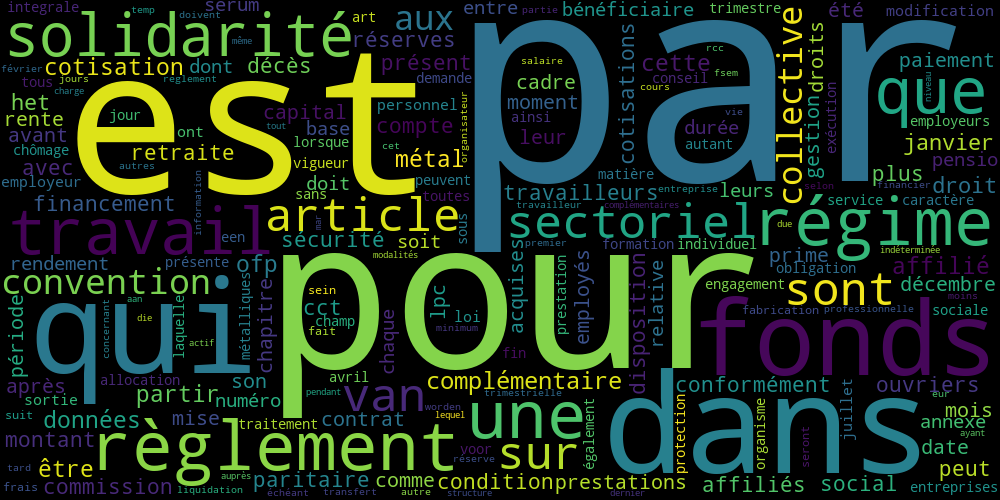

In [117]:
t_texts, t_f_abs, t_f_rel, t_wordcloud = filter_words(t_ts, freq_min=0.05, freq_max=0.95)
t_wordcloud.to_image()

In [128]:
{k: f_rel[k] for k in list(f_rel) if f_rel[k] > 0.5}

{'dans': 0.7370656370656371,
 'est': 0.9081081081081082,
 'fonds': 0.6355212355212355,
 'par': 1.0,
 'pour': 0.9420849420849421,
 'qui': 0.6444015444015444,
 'règlement': 0.5633204633204634,
 'régime': 0.5235521235521235,
 'une': 0.5181467181467182}

In [133]:
# most common words all docs to be removed for all
all_ts = tokenize_texts(responses2.bodies_cleaned)
texts, f_abs, f_rel, wordcloud = filter_words(all_ts, freq_min=0.5)
f_rel

{'article': 0.5043872919818457,
 'collective': 0.5338376197680282,
 'convention': 0.5625819465456379,
 'dans': 0.7122541603630862,
 'est': 0.7416036308623298,
 'par': 0.9238527483610691,
 'pension': 0.6362077660110943,
 'pour': 0.9525970751386788,
 'qui': 0.567826525466465,
 'travail': 1.0,
 'une': 0.5035804336863339}

In [140]:
stop_words = list(f_rel.values())

In [144]:
t = themes_fr[0]
print(t)
# for t in themes_fr
mask = responses2.dropna(axis=0, subset=['themesFr']).themesFr.map(lambda x: t in x)
r_t = responses2.dropna(axis=0, subset=['themesFr'])[mask]
t_ts = tokenize_texts(r_t["bodies_cleaned"], stop_words=stop_words)

PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES


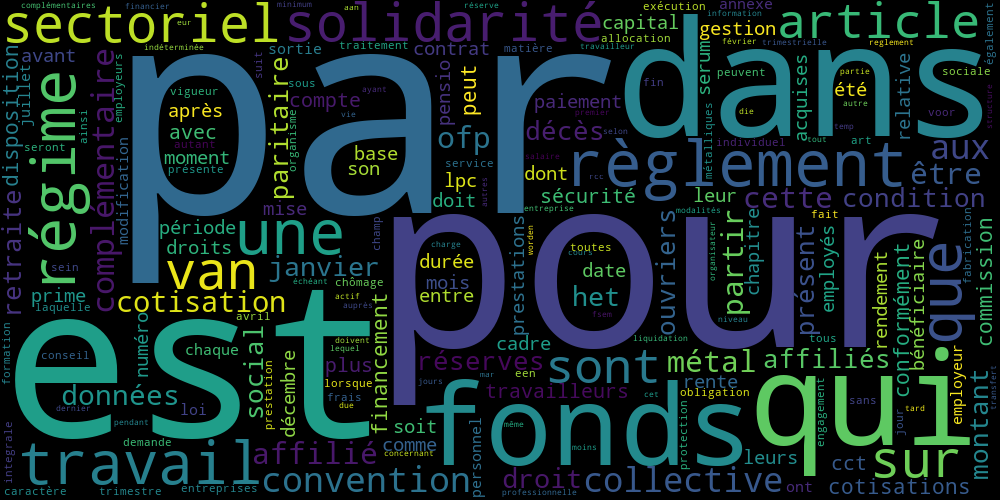

In [145]:
t_texts, t_f_abs, t_f_rel, t_wordcloud = filter_words(t_ts, freq_min=0.05, freq_max=0.95)
t_wordcloud.to_image()